In [157]:
# data @ https://finance.yahoo.com/quote/NVDA/history/
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import layers
from copy import deepcopy 

In [158]:
df = pd.read_csv('NVDA.csv')
df = df[['Date','Close']] # take relevant data
df['Date']
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return dt.datetime(year=year,month=month,day=day)

datetime_obj = str_to_datetime('1999-01-22')

df['Date'] = df['Date'].apply(str_to_datetime) # Turn dates into datetime objects (not strings)
df.index = df.pop('Date')
df

,Close
Date,
1999-01-22,0.041016
1999-01-25,0.045313
1999-01-26,0.041797
1999-01-27,0.041667
1999-01-28,0.041536
...,...
2024-06-14,131.880005
2024-06-17,130.979996
2024-06-18,135.580002


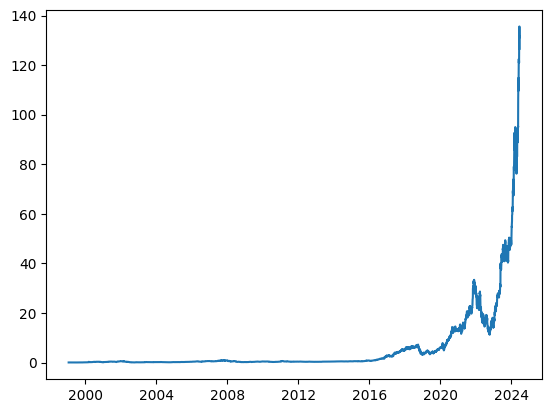

In [159]:
plt.plot(df.index,df['Close'])

In [160]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date 

    dates = [] 
    X, Y = [], [] 

    last_time = False 
    while True: 
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1: 
            print(f'Error: Window size of {n} too large for date {target_date}')
            return 
        values = df_subset['Close'].to_numpy() 
        x,y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x) 
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+dt.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day 
        next_date = dt.datetime(day=int(day), month=int(month), year=int(year))

        if last_time: 
            break 
        target_date = next_date 

        if target_date == last_date: 
            last_time = True 
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates 
    
    X = np.array(X) 
    for i in range(0,n):
        X[:,i]
        ret_df[f'Target-{n-i}'] = X[:,i]

    ret_df['Target'] = Y

    return ret_df 

windowed_df = df_to_windowed_df(df, '2023-12-22', '2024-06-21', 3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2023-12-22,49.604000,48.111000,48.990002,48.830002
1,2023-12-26,48.111000,48.990002,48.830002,49.278999
2,2023-12-27,48.990002,48.830002,49.278999,49.417000
3,2023-12-28,48.830002,49.278999,49.417000,49.521999
4,2023-12-29,49.278999,49.417000,49.521999,49.521999
...,...,...,...,...,...
119,2024-06-14,120.910004,125.199997,129.610001,131.880005
120,2024-06-17,125.199997,129.610001,131.880005,130.979996
121,2024-06-18,129.610001,131.880005,130.979996,135.580002
122,2024-06-20,131.880005,130.979996,135.580002,130.779999


In [161]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    
    dates = df_as_np[:,0] # extract the dates 

    # extract input matrix
    middle_matrix = df_as_np[:,1:-1]
    X = middle_matrix.reshape((len(dates),middle_matrix.shape[1],1))

    Y = df_as_np[:,-1] # extract output

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((124,), (124, 3, 1), (124,))

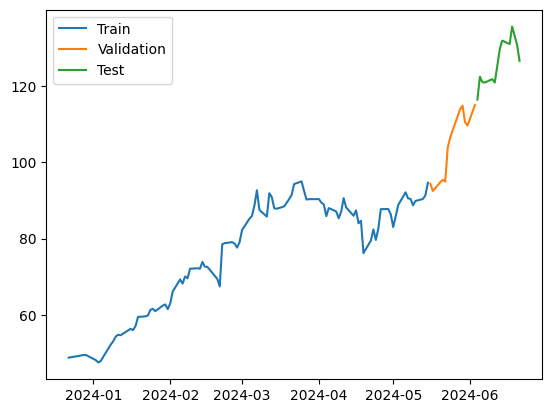

In [162]:
# Train Validation Test Split 
q_80 = int(len(dates)*0.8)
q_90 = int(len(dates)*0.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend(['Train','Validation','Test'])

In [163]:
# for n = 3, univariate forecasting
model = Sequential([layers.Input((3,1)),
                    layers.LSTM(64, return_sequences=False), # bigger the number, more complicated model = more overfiting
                    layers.Dropout(0.1),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)]) #output

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics = ['mean_absolute_error'])

model.fit(X_train,y_train, validation_data=(X_val,y_val),epochs=100)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 6060.9453 - mean_absolute_error: 76.5006 - val_loss: 10879.0586 - val_mean_absolute_error: 103.9499
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5999.8301 - mean_absolute_error: 76.0503 - val_loss: 10801.9678 - val_mean_absolute_error: 103.5783
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5869.1665 - mean_absolute_error: 75.1334 - val_loss: 10726.9043 - val_mean_absolute_error: 103.2150
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6135.9360 - mean_absolute_error: 77.0593 - val_loss: 10676.0430 - val_mean_absolute_error: 102.9680
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5956.7710 - mean_absolute_error: 75.8557 - val_loss: 10617.2031 - val_mean_absolute_error: 102.6816
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5775.7700 - mean_absolute_error: 74.5484 - val_loss: 10544.1650 - val_mean_absolute_error: 102.3251
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step -

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


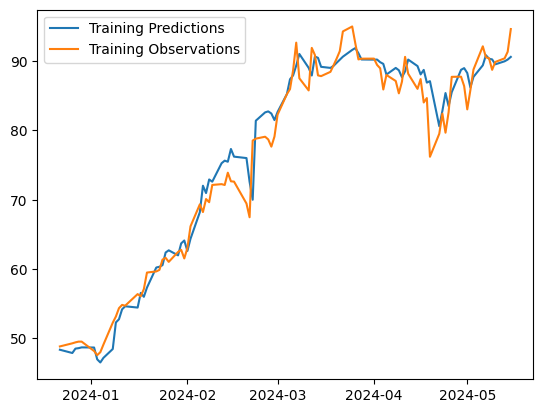

In [164]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions','Training Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


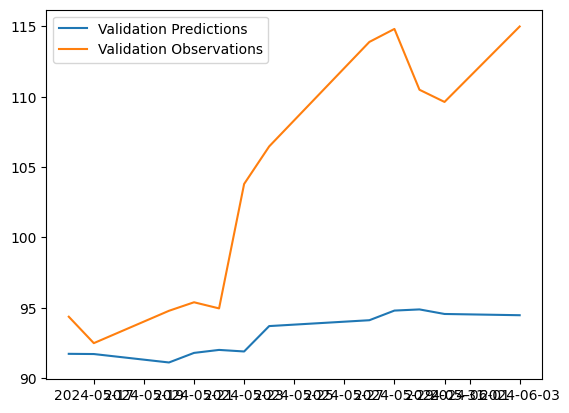

In [165]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions','Validation Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


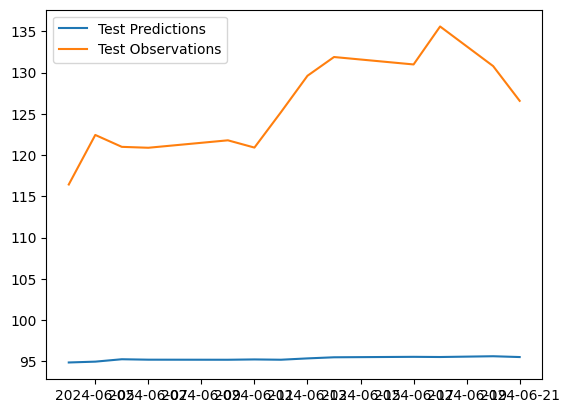

In [166]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions','Test Observations'])

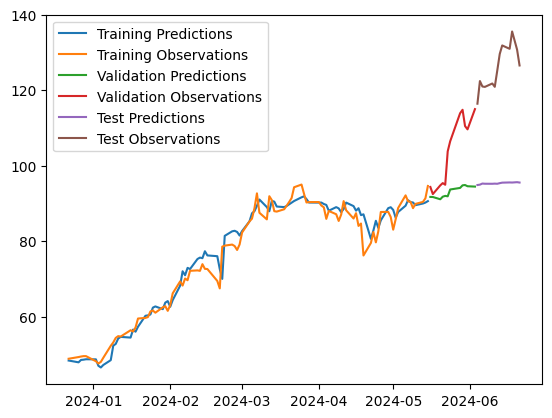

In [167]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)

plt.legend(['Training Predictions','Training Observations',
            'Validation Predictions','Validation Observations',
            'Test Predictions','Test Observations'])

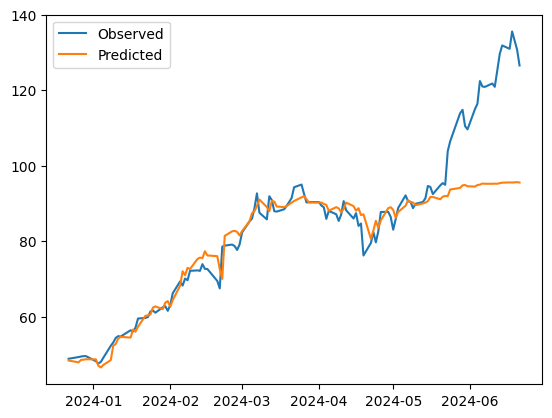

In [180]:
dates
lstm_preds = np.concatenate((train_predictions,val_predictions,test_predictions)) 

plt.plot(dates, y)
plt.plot(dates, lstm_preds)
plt.legend(['Observed','Predicted'])